## Implementation of Transformer for machine translation
### The __torchtext.data__ may through an error stating `no module found named "Field"` which probably arises due to deprecation of this module in the newer version of torch. Execute the cell below to install the `torchtext version 0.6.0` to run the notebook. This is because the _Field_ and _TabularDataset_ makes the vocabulary and dataloader creation much simpler.
```python
pip install torchtext==0.6.0
print(torchtext.__version__)
```

In [1]:
# pip install torchtext==0.6.0
# print(torchtext.__version__)

In [32]:
import torch
import torchtext
from torchtext import vocab
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data import Field, BucketIterator, TabularDataset
from torch import Tensor
from torch.nn import TransformerEncoder, TransformerDecoder,TransformerEncoderLayer, TransformerDecoderLayer
import torch.optim as optim
import os
import random
from collections import Counter
import warnings
import re, string
import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from string import digits
warnings.filterwarnings("ignore")

In [33]:
def preprocess(text):
    """
    Convert all the text into lower letters
    Remove the words betweent brakets ()
    Remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    Replace these special characters with space:
    Replace extra white spaces with single white spaces
    """
    text = re.sub(r"([?.!,])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    text = re.sub('[$)\"’°;\'€%:,(/]', '', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\u200d', ' ', text)
    text = re.sub('\u200c', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub('  ', ' ', text)
    text = re.sub('   ', ' ', text)
    text =" ".join(text.split())
    return text

#### Change the l variable to the language you want to translate to..

In [76]:
# Set the dataset name
l = "tamil"
# Read the CSV file from the specified directory into a DataFrame
data = pd.read_csv('../Data/{}.csv'.format(l))

# Drop the unnecessary columns "Unnamed: 0" and "entry_id" from the DataFrame
data.drop(["Unnamed: 0", "entry_id"], inplace=True, axis=1)

# Note: The next operation seems redundant as "entry_id" has already been dropped.
# Rename the column "entry_id" to "id" (if it exists)
data = data.rename(columns={"entry_id": "id"})

# Display the first 10 rows of the cleaned DataFrame 
# (This will be visible in interactive environments like Jupyter Notebook)
data.head(10)

# Write the cleaned data back to a new CSV file in the current directory
data.to_csv("{}.csv".format(l), index=False)


In [77]:
# Reading the cleaned data
data = pd.read_csv("{}.csv".format(l))
data.head(10)

,english,tamil
0,The nature and scope of trafficking range from...,தொழில்துறை மற்றும் உள்நாட்டு தொழிலாளர் இருந்...
1,Kerala is her heart and agrarian Palakkad can ...,"கேரளா அவரது இதயம் என்றும், மற்றும் பாலக்காடு வ..."
2,what's the weather like right now in new york,சென்னையில் இப்போது வானிலை எப்படி இருக்கிறது
3,tell me how to cook a cheese souffle,சீஸ் சூப் எப்படி சமைக்க வேண்டும் என்று சொல்லுங...
4,These structures are made of beautifully carve...,இந்த கட்டமைப்புகள் அழகாக செதுக்கப்பட்ட கற்களால...
5,"Travel to the city, Kochi, that has moved so b...","கொச்சி நகரத்திற்கு பயணம் செய்யுங்கள், வரலாற்றி..."
6,"It is at an altitude of 2,438 metres (7,999 ft...",இது நாகாலாந்தில் உள்ள ஜாப்ஃபூ மலைக்கு பின்புறம...
7,Any portion of your funds that are unused will...,பங்குத் தொகுப்புகளுக்கான விருப்பங்கள் விநியோகி...
8,"Founded in 1787 by the East India Company, the...","20 கி.மீ –ல், 1787-ல் கிழக்கு இந்திய கம்பெனியா..."
9,A population mean volume of 650 ml would be co...,650 மில்லி ஒரு மக்கள் சராசரி அளவு குறைந்த கருத...


In [78]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [79]:
def tokenizer(text): 
    """
    Tokenize the input text.
    
    Parameters:
    - text (str): Input text to be tokenized.
    
    Returns:
    - list: List of tokens.
    """
    return [tok for tok in preprocess(text).split()]

# Define Fields for tokenization and preprocessing
lang = Field(tokenize = tokenizer, lower = True, init_token = "<sos>", eos_token = "<eos>")
eng = Field(tokenize = tokenizer, lower = True, init_token = "<sos>", eos_token = "<eos>")

# Define data fields for loading the dataset
datafields = [("english", eng), ("{}".format(l), lang)]
# Load the dataset from a CSV file
dataset = TabularDataset(path="{}.csv".format(l), format='csv', skip_header=True, fields=datafields)
# Split the dataset into training and validation sets
train_data, val_data = dataset.split(split_ratio = 0.80)

# Build vocabulary for each language from the training data
lang.build_vocab(train_data, min_freq = 1, max_size = 50000)
eng.build_vocab(train_data, min_freq = 1, max_size = 50000)

# creating the train and validation data iterator for training
train_iterator, val_iterator = BucketIterator.splits(
    (train_data, val_data), 
    batch_size = 8, 
    device = device, 
    sort_key = lambda x: getattr(x,l),  # change the language after x.
    sort_within_batch = True)

In [80]:
print(len(eng.vocab))
print(len(lang.vocab))

42882
50004


In [70]:
class TransformerMT(nn.Module):
    """
    Custom Transformer model for Machine Translation (MT).
    
    This model consists of an encoder and a decoder, both built using the Transformer architecture.
    
    Parameters:
    - nhead (int): Number of heads in the multihead attention mechanism.
    - embed_size (int): Dimension of the embedding vector.
    - source_vocab_size (int): Size of the source vocabulary.
    - target_vocab_size (int): Size of the target vocabulary.
    - num_encoder_layers (int): Number of layers in the transformer encoder.
    - num_decoder_layers (int): Number of layers in the transformer decoder.
    - ffnn_size (int, optional): Size of the feedforward neural network inside transformer layers. Default is 512.
    """
    
    def __init__(self, 
                 nhead: int,
                 embed_size: int, 
                 source_vocab_size: int, 
                 target_vocab_size: int,
                 num_encoder_layers: int, 
                 num_decoder_layers: int,
                 ffnn_size:int = 512):
        
        super(TransformerMT, self).__init__()
        
        # Define encoder and decoder layers
        encoder_layer = TransformerEncoderLayer(d_model = embed_size, nhead = nhead, dim_feedforward = ffnn_size)
        decoder_layer = TransformerDecoderLayer(d_model = embed_size, nhead = nhead, dim_feedforward = ffnn_size)
        
        # Initialize transformer encoder, decoder, and final fully connected layer
        self.tf_encoder = TransformerEncoder(encoder_layer, num_layers = num_encoder_layers)
        self.tf_decoder = TransformerDecoder(decoder_layer, num_layers = num_decoder_layers)
        self.fc_layer = nn.Linear(embed_size, target_vocab_size)
        
        # Embedding layers for tokens and positional information
        self.src_token_embedding = TokenEmbedding(source_vocab_size, embed_size)
        self.tar_token_embedding = TokenEmbedding(target_vocab_size, embed_size)
        self.positional_embedding = SinusoidalEmbedding(embed_size, dropout = DROPOUT_RATE)

    def forward(self, 
                source: Tensor,
                target: Tensor,
                source_mask: Tensor,
                target_mask: Tensor,
                source_padding_mask: Tensor,
                target_padding_mask: Tensor, 
                memory_key_padding_mask: Tensor):
        """
        Forward pass of the TransformerMT model.
        
        Parameters:
        - source (torch.Tensor): Source sequence tensor.
        - target (torch.Tensor): Target sequence tensor.
        - source_mask (torch.Tensor): Source sequence mask.
        - target_mask (torch.Tensor): Target sequence mask.
        - source_padding_mask (torch.Tensor): Source padding mask.
        - target_padding_mask (torch.Tensor): Target padding mask.
        - memory_key_padding_mask (torch.Tensor): Memory key padding mask.
        
        Returns:
        - torch.Tensor: Output tensor after passing through the transformer and the fully connected layer.
        """
        
        source_embedding = self.positional_embedding(self.src_token_embedding(source))
        target_embedding = self.positional_embedding(self.tar_token_embedding(target))
        memory = self.tf_encoder(source_embedding, source_mask, source_padding_mask)
        outputs = self.tf_decoder(target_embedding, 
                                  memory, 
                                  target_mask, 
                                  None,
                                  target_padding_mask,
                                  memory_key_padding_mask)
        outputs = self.fc_layer(outputs)
        return outputs

    def encode(self, source: Tensor, source_mask: Tensor):
        """
        Encode the source sequence using the transformer encoder.
        
        Parameters:
        - source (torch.Tensor): Source sequence tensor.
        - source_mask (torch.Tensor): Source sequence mask.
        
        Returns:
        - torch.Tensor: Encoded memory tensor.
        """
        token_rep = self.src_token_embedding(source)
        positional_rep = self.positional_embedding(token_rep)
        encoder_output = self.tf_encoder(positional_rep, source_mask)
        return encoder_output

    def decode(self, target: Tensor, memory: Tensor, target_mask: Tensor):
        """
        Decode the memory tensor using the transformer decoder.
        
        Parameters:
        - target (torch.Tensor): Target sequence tensor.
        - memory (torch.Tensor): Encoded memory tensor.
        - target_mask (torch.Tensor): Target sequence mask.
        
        Returns:
        - torch.Tensor: Decoded tensor.
        """
        token_rep = self.src_token_embedding(target)
        positional_rep = self.positional_embedding(token_rep)
        decoder_output = self.tf_decoder(positional_rep, memory, target_mask)
        return decoder_output
        


In [23]:
class SinusoidalEmbedding(nn.Module):
    """
    Sinusoidal Positional Encoding for Transformer models.
    
    The positional encoding module uses sine and cosine functions of different frequencies to 
    encode the position of tokens in the sequence.
    
    Parameters:
    - embed_size (int): Dimension of the embedding vector.
    - dropout (float): Dropout rate for the dropout layer.
    - max_len (int, optional): Maximum length of the sequence. Default is 5000.
    """
    
    def __init__(self, embed_size, dropout, max_len = 5000):
        super(SinusoidalEmbedding, self).__init__()
        self.dropout = nn.Dropout(p = dropout)
        
        # Compute the sinusoidal positional encodings
        denom = max_len*2
        pdist = torch.exp(- torch.arange(0, embed_size, 2) * math.log(denom) / embed_size)
        position = torch.arange(0, max_len).reshape(max_len, 1)
        position_embedding = torch.zeros((max_len, embed_size))
        position_embedding[:, 0::2] = torch.sin(position * pdist)
        position_embedding[:, 1::2] = torch.cos(position * pdist)
        position_embedding = position_embedding.unsqueeze(-2)
        
        # Register the position embeddings so they get saved with the model's state_dict
        self.register_buffer('position_embedding', position_embedding)

    def forward(self, token_embed):
        """
        Forward pass of the SinusoidalEmbedding.
        
        Parameters:
        - token_embed (torch.Tensor): Token embeddings.
        
        Returns:
        - torch.Tensor: Token embeddings added with positional encodings.
        """
        outputs = token_embed + self.position_embedding[:token_embed.size(0),:]
        outputs = self.dropout(outputs)
        return outputs


class TokenEmbedding(nn.Module):
    """
    Token Embedding module for Transformer models.
    
    This module converts token indices into dense vectors of fixed size, embed_size. 
    The embeddings are scaled by the square root of their dimensionality.
    
    Parameters:
    - vocab_size (int): Size of the vocabulary.
    - embed_size (int): Dimension of the embedding vector.
    """
    
    def __init__(self, vocab_size, embed_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.embed_size = embed_size
        
    def forward(self, tokens):
        """
        Forward pass of the TokenEmbedding.
        
        Parameters:
        - tokens (torch.Tensor): Tensor of token indices.
        
        Returns:
        - torch.Tensor: Scaled token embeddings.
        """
        outputs = self.embedding(tokens.long())
        outputs_scaled = outputs * math.sqrt(self.embed_size)
        return outputs_scaled

In [24]:
def generate_square_subsequent_mask(sz):
    """
    Generate a square mask for the sequence, where the mask indicates subsequent positions.
    This mask is used to ensure that a position cannot attend to subsequent positions in the sequence.
    
    Parameters:
    - sz (int): Size of the sequence.
    
    Returns:
    - torch.Tensor: Mask tensor of shape (sz, sz) with 0s in positions that can be attended to and negative infinity elsewhere.
    """
    
    mask = (torch.triu(torch.ones((sz, sz), device=device)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

def create_mask(source, target):
    """
    Create masks for the source and target sequences.
    
    Parameters:
    - source (torch.Tensor): Source sequence tensor.
    - target (torch.Tensor): Target sequence tensor.
    
    Returns:
    - tuple: A tuple containing source mask, target mask, source padding mask, and target padding mask.
    """
    
    source_seq_len = source.shape[0]
    target_seq_len = target.shape[0]
    batch_size = source.shape[1]
    source_mask = torch.zeros((source_seq_len, source_seq_len), device=device).type(torch.bool)
    target_mask = generate_square_subsequent_mask(target_seq_len)
    source_padding_mask = (source == PAD_IDX).transpose(0, 1)
    target_padding_mask = (target == PAD_IDX).transpose(0, 1)
    return source_mask, target_mask, source_padding_mask, target_padding_mask


In [25]:
SRC_VOCAB_SIZE = len(eng.vocab)  # Source vocabulary size (English)
TAR_VOCAB_SIZE = len(lang.vocab)  # Target vocabulary size (Other language, inferred from 'lang' variable)
EMBEDDING_SIZE = 512  # Size of the embedding vector
NHEAD = 8  # Number of heads in the multihead attention mechanism
FFNN_DIM = 512  # Dimension of the feed-forward neural network inside transformer layers
BATCH_SIZE = 32  # Size of each training batch
NUM_ENCODER_LAYERS = 3  # Number of layers in the transformer encoder
NUM_DECODER_LAYERS = 3  # Number of layers in the transformer decoder
LEARNING_RATE = 0.0001  # Learning rate for the optimizer
DROPOUT_RATE = 0.1  # Dropout rate for the dropout layer
NUM_EPOCHS = 50  # Number of epochs for training
PAD_IDX = eng.vocab.stoi["<pad>"]  # Index for the padding token
SOS_IDX = eng.vocab.stoi["<sos>"] # index for start token
EOD_IDX = eng.vocab.stoi["<eos>"] # index for end token


# Instantiate the TransformerMT model with the specified configuration
model = TransformerMT(NHEAD,
                      EMBEDDING_SIZE,
                      SRC_VOCAB_SIZE, 
                      TAR_VOCAB_SIZE,
                      NUM_ENCODER_LAYERS, 
                      NUM_DECODER_LAYERS, 
                      FFNN_DIM)

# Initialize the model's parameters using the Xavier uniform initializer
# This helps in achieving a better distribution of activations
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

# Move the model to the specified device (either GPU or CPU)
model = model.to(device)

# Define the loss criterion
# CrossEntropyLoss is used since this is a classification task, and we ignore the loss computed on padding tokens
criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

# Define the optimizer to be used for training
# Adam optimizer is used with specific betas and epsilon values
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE, betas=(0.9, 0.98), eps=1e-9)

In [26]:
print(model)

TransformerMT(
  (tf_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (tf_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (multihead_att

In [27]:
SOS_IDX = eng.vocab.stoi["<sos>"]
EOS_IDX = eng.vocab.stoi["<eos>"]

def get_tokens(model, source, source_mask, max_len, start_symbol):
    """
    Get token indices from a given source sequence using a trained model.
    
    Parameters:
    - model (nn.Module): The trained transformer model.
    - source (torch.Tensor): The source sequence tensor.
    - source_mask (torch.Tensor): The mask for the source sequence.
    - max_len (int): Maximum length of the target sequence.
    - start_symbol (int): The starting symbol for the target sequence.
    
    Returns:
    - result (torch.Tensor): The tensor containing token indices of the target sequence.
    """
    
    # Move source and its mask to device
    source_mask = source_mask.to(device)
    source = source.to(device)
    
    # Encode the source sequence
    memory = model.encode(source, source_mask)
    
    # Initialize result tensor with the start symbol
    result = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(device)
                
    # Decode the memory tensor to get the target sequence
    for index in range(max_len - 1):
        memory = memory.to(device)
        memory_mask = torch.zeros(result.shape[0], memory.shape[0]).to(device).type(torch.bool)
        target_mask = (generate_square_subsequent_mask(result.size(0)).type(torch.bool)).to(device)
        output = model.decode(result, memory, target_mask)
        output = output.transpose(0, 1)
        
        # Get the next word's probability distribution and find the word with the maximum probability
        probs = model.fc_layer(output[:, -1])
        _, next_word = torch.max(probs, dim = 1)
        next_word = next_word.item()
        
        # Add the next word to the result
        result = torch.cat([result,torch.ones(1, 1).type_as(source.data).fill_(next_word)], dim=0)
        
        # Break if the next word is the start of sequence symbol
        if next_word == SOS_IDX:
            break
            
    return result


def translate(model, source, source_vocab, target_vocab):
    """
    Translate a given source sequence to a target sequence using a trained model.
    
    Parameters:
    - model (nn.Module): The trained transformer model.
    - source (str or torch.Tensor): The source sequence (string or tensor).
    - source_vocab (Vocab): Vocabulary object for the source language.
    - target_vocab (Vocab): Vocabulary object for the target language.
    
    Returns:
    - str: The translated sequence.
    """
    
    # Set the model to evaluation mode
    model.eval()
    
    # Convert source string to tensor, if it's a string
    if type(source) == str:
        tokens = [SOS_IDX] + [source_vocab.vocab.stoi[tok] for tok in source.split()] + [EOS_IDX]
    else: 
        tokens = source
    num_tokens = len(tokens)
    source = (torch.LongTensor(tokens).reshape(num_tokens, 1))
    source_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)

    # Get target token indices from the source tensor
    target_tokens = get_tokens(model, source, source_mask, max_len = num_tokens + 5, start_symbol = SOS_IDX).flatten()

    # Convert target token indices to string
    return " ".join([target_vocab.vocab.itos[token] for token in target_tokens]).replace("<sos>", "").replace("<eos>", "").replace("<unk>", "")


In [28]:
def train():
    """
    Train the model using the training data.
    
    This function carries out a single epoch of training. For each batch of data in the training dataset:
    - The model's gradients are zeroed.
    - The data is passed through the model to get predictions.
    - The loss between the predictions and actuals is computed.
    - The gradients are computed via backpropagation.
    - The model's parameters are updated.
    
    Returns:
    - float: Average training loss for the epoch.
    """
    
    # Set the model to training mode and move it to the device
    model.train().to(device)
    losses = 0  # Accumulator for the total loss

    # Iterate over each batch in the training data
    for batch_idx, batch in enumerate(train_iterator):
        train_loss = 0  # Accumulator for batch loss

        # Extract source and target sequences from the batch and move them to the device
        src = batch.english.to(device)
        target = getattr(batch, l).to(device)
        
        # Exclude the last token for target input
        target_input = target[:-1,:]

        # Generate masks for the source and target sequences
        source_mask, target_mask, src_padding_mask, tar_padding_mask = create_mask(src, target_input)
        
        # Pass data through the model
        output = model(src, 
                       target_input, 
                       None, 
                       target_mask, 
                       src_padding_mask, 
                       tar_padding_mask, 
                       src_padding_mask)
        
        # Reset model gradients
        optimizer.zero_grad()
        
        # Reshape output for loss computation
        output = output.reshape(-1, output.shape[-1])
        output_target = target[1:,:].reshape(-1)
        
        # Compute the loss and backpropagate
        loss = criterion(output, output_target)
        loss.backward()
        
        # Clip gradients to avoid exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 3)
        
        # Update model parameters
        optimizer.step()
        
        # Update loss accumulators
        losses += loss.item()
        train_loss += ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        
        # Print the loss for every 100 batches and also translate a sample sentence
        if batch_idx % 100 == 0:
            print(f'Train loss at step {batch_idx}: {train_loss:.3f}')
            print(translate(model, "Football is a tough game", eng, lang))
    
    # Return average training loss for the epoch
    return losses/len(train_iterator)

def validate():
    """
    Validate the model using the validation data.
    
    This function computes the model's performance on the validation dataset. 
    No parameter updates are performed during this stage.
    
    Returns:
    - float: Average validation loss.
    """
    
    # Set the model to evaluation mode and move it to the device
    model.eval().to(device)
    losses = 0  # Accumulator for the total loss

    # Ensure no computation graph is built during validation
    with torch.no_grad():
        
        # Iterate over each batch in the validation data
        for batch_idx, batch in enumerate(val_iterator):
            
            # Extract source and target sequences from the batch and move them to the device
            src = batch.english.to(device)
            target = getattr(batch, l).to(device)
            
            # Exclude the last token for target input
            target_input = target[:-1,:]

            # Generate masks for the source and target sequences
            source_mask, target_mask, src_padding_mask, tar_padding_mask = create_mask(src, target_input)
            
            # Pass data through the model
            output = model(src, 
                           target_input, 
                           source_mask, 
                           target_mask, 
                           src_padding_mask, 
                           tar_padding_mask, 
                           src_padding_mask)
            
            # Reshape output for loss computation
            output = output.reshape(-1, output.shape[-1])
            output_target = target[1:,:].reshape(-1)
            
            # Compute the loss
            loss = criterion(output, output_target)
            
            # Update loss accumulator
            losses += loss.item()

    # Return average validation loss
    return losses/len(val_iterator)


In [29]:
def train_and_validate(num_epochs, patience):
    """
    Trains and validates the model over a specified number of epochs.
    Implements early stopping based on the validation loss.
    
    Parameters:
    - num_epochs (int): Maximum number of epochs to train.
    - patience (int): Number of epochs to wait without improvement before stopping training.
    
    Returns:
    - list: A list of training losses over the epochs.
    - list: A list of validation losses over the epochs.
    """
    
    # Initialize the best validation loss to a high value
    best_val_loss = float('inf')
    epochs_without_improvement = 0  # Counter for epochs without validation loss improvement
    train_losses, val_losses = [], []  # Lists to store training and validation losses
    
    # Loop over epochs
    for epoch in range(1, num_epochs + 1):
        start_time = time.time()
        
        # Training phase
        train_loss = train()
        train_losses.append(train_loss)
        
        # Validation phase
        val_loss = validate()
        val_losses.append(val_loss)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        # Print training and validation statistics for the epoch
        print(f'Epoch: {epoch}/{num_epochs}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\tVal Loss: {val_loss:.3f}')
        print(f'\tEpoch time: {elapsed_time:.3f}s')
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the current state of the model if validation loss is the best seen so far
            torch.save(model.state_dict(), "best_model_{}.pt".format(l))
        else:
            epochs_without_improvement += 1
            # Stop training if validation loss hasn't improved for a number of epochs specified by 'patience'
            if epochs_without_improvement >= patience:
                print("Stopping training due to early stopping criteria!")
                break

    # Load the best model weights after all epochs are completed or early stopping is triggered
    model.load_state_dict(torch.load("best_model_{}.pt".format(l)))
    
    return train_losses, val_losses

# Train and validate the model for a specified number of epochs with early stopping criteria
train_losses, val_losses = train_and_validate(NUM_EPOCHS, 2)

Train loss at step 0: 10.843
 অসাধরণ অসাধরণ অসাধরণ তুলেছে। তুলেছে। তুলেছে। তুলেছে। তুলেছে। তুলেছে। কোদুঙ্গালুরে ভীষণ
Train loss at step 100: 0.080
           
Train loss at step 200: 0.038
           
Train loss at step 300: 0.026
           
Train loss at step 400: 0.020
           
Train loss at step 500: 0.016
           
Train loss at step 600: 0.013
           
Train loss at step 700: 0.011
           
Train loss at step 800: 0.009
 আমার কি কি কি       
Train loss at step 900: 0.009
 কি কি কি        
Train loss at step 1000: 0.008
 কি কি কি        
Train loss at step 1100: 0.008
 আমার কি কি        
Train loss at step 1200: 0.006
 কি কি         
Train loss at step 1300: 0.006
 কি কি কি কি       
Train loss at step 1400: 0.006
 কি কি কি        
Train loss at step 1500: 0.005
 কি কি কি        
Train loss at step 1600: 0.005
 আমার কি কি কি       
Train loss at step 1700: 0.004
 কি কি কি        
Train loss at step 1800: 0.004
 কি কি কি কি       
Train loss at step 1900: 0.004
 কি কি কি

Train loss at step 1500: 0.004
 একটি একটি একটি একটি       
Train loss at step 1600: 0.004
 একটি একটি একটি        
Train loss at step 1700: 0.003
 একটি একটি একটি        
Train loss at step 1800: 0.003
 একটি একটি একটি আছে       
Train loss at step 1900: 0.003
 একটি একটি একটি        
Train loss at step 2000: 0.003
 একটি একটি একটি        
Train loss at step 2100: 0.003
 একটি একটি         
Train loss at step 2200: 0.003
 একটি একটি একটি        
Train loss at step 2300: 0.002
 একটি একটি একটি        
Train loss at step 2400: 0.003
 কি একটি একটি        
Train loss at step 2500: 0.003
 একটি একটি একটি        
Train loss at step 2600: 0.003
 একটি একটি         
Train loss at step 2700: 0.002
 একটি একটি একটি হয়       
Train loss at step 2800: 0.002
 একটি একটি একটি        
Train loss at step 2900: 0.002
 একটি একটি একটি        
Train loss at step 3000: 0.002
 একটি একটি একটি        
Train loss at step 3100: 0.002
 একটি একটি একটি        
Train loss at step 3200: 0.002
 একটি একটি একটি        
Train loss

Train loss at step 2400: 0.002
 একটি একটি একটি        
Train loss at step 2500: 0.002
 কি একটি একটি        
Train loss at step 2600: 0.002
 খেলা একটি একটি খুব       
Train loss at step 2700: 0.002
  একটি একটি        
Train loss at step 2800: 0.002
 কি একটি একটি        
Train loss at step 2900: 0.002
 কি একটি একটি        
Train loss at step 3000: 0.002
 কি একটি একটি        
Train loss at step 3100: 0.001
 কি একটি একটি        
Train loss at step 3200: 0.001
 কি একটি একটি        
Train loss at step 3300: 0.001
 একটি একটি খেলা        
Train loss at step 3400: 0.001
 কি একটি খেলা        
Train loss at step 3500: 0.001
 একটি একটি একটি        
Train loss at step 3600: 0.001
 একটি একটি খেলা        
Train loss at step 3700: 0.001
 একটা একটি একটি        
Train loss at step 3800: 0.001
 কি একটি খেলা        
Train loss at step 3900: 0.001
  একটি একটি        
Train loss at step 4000: 0.001
 একটি একটি একটি একটি       
Train loss at step 4100: 0.001
 একটি খেলা একটি        
Train loss at step 4200: 0.

Train loss at step 3200: 0.001
 একটা একটা একটা        
Train loss at step 3300: 0.001
 একটা একটা একটা খেলা খেলা      
Train loss at step 3400: 0.001
 একটা একটা খেলা খেলা       
Train loss at step 3500: 0.001
 একটা একটা একটা খেলা       
Train loss at step 3600: 0.001
 একটা একটা একটা খেলা খেলা      
Train loss at step 3700: 0.001
 একটা একটা একটা খেলা খেলা      
Train loss at step 3800: 0.001
  একটি একটি একটি       
Train loss at step 3900: 0.001
  একটি একটি        
Train loss at step 4000: 0.001
 এটি একটি একটি        
Train loss at step 4100: 0.001
 একটি একটি একটি এটি       
Train loss at step 4200: 0.001
 একটি একটি একটি এটি       
Train loss at step 4300: 0.001
 এটি একটি একটি        
Train loss at step 4400: 0.001
 এটি একটি একটি        
Train loss at step 4500: 0.001
 কঠিন একটা একটা        
Train loss at step 4600: 0.001
 খুব একটা একটা        
Train loss at step 4700: 0.001
 কঠিন একটা একটা খেলা খেলা      
Train loss at step 4800: 0.001
 এটি একটি এটি এটি       
Train loss at step 4900: 0

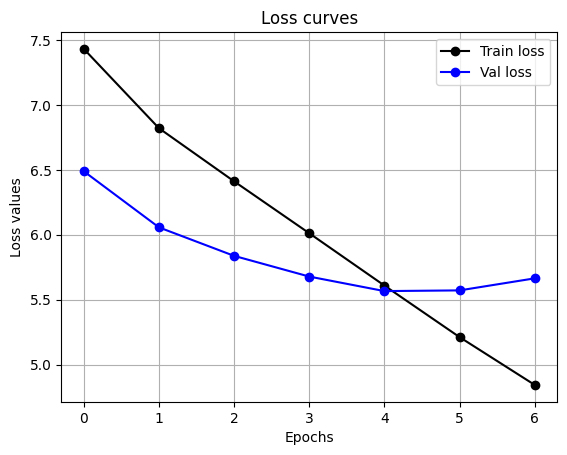

In [69]:
# Define the directory to save the plots.
PLOT_DIR = "transformer_plots"

# Check if the directory exists. If not, create it.
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

def plotresults():
    """
    Function to plot training and validation loss over epochs.

    The function uses the matplotlib library to plot the loss curves for 
    training and validation data. It saves the generated plot in the specified
    directory (`plot_dir`) with a filename based on the language (`l`).
    """
    # Plotting the training loss (in black color with circle markers).
    plt.plot(range(len(train_losses)), train_losses, marker = "o", color = "black")

    # Plotting the validation loss (in blue color with circle markers).
    plt.plot(range(len(val_losses)), val_losses, marker = "o", color = "blue")

    # Adding legend to distinguish between train and validation curves.
    plt.legend(["Train loss", "Val loss"])

    # Adding title and axis labels to the plot.
    plt.title("Loss curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss values")

    # Displaying grid for better visualization.
    plt.grid()

    # Save the plot as a PNG image in the specified directory with a filename
    # based on the language (`l`).
    plt.savefig(os.path.join(PLOT_DIR,"loss_{}.png".format(l)))

plotresults()

In [19]:
# Inference
# Check if the "Translations" directory exists. If not, create it.
if not os.path.exists("transformer_translations"):
    os.makedirs("transformer_translations")

def evaluate(language):
    """
    Function to evaluate and generate translations for given test data.
    
    This function reads a CSV file containing English sentences, 
    translates each sentence to the target language using the 
    trained model, and then saves the translations to a new CSV file.

    Parameters:
    - language: The target language for translation.

    Outputs:
    - A CSV file named "answer1_{language}_test.csv" saved in the "Translations" directory.
      This file contains the original English sentences and their corresponding translations.
    """
    # List to store the predicted translations.
    predictions = []

    # Read the test data from the specified CSV file.
    data = pd.read_csv("./../testData/testEnglish-{}.csv".format(language))

    # Loop through each row (sentence) in the test data.
    for idx, row in data.iterrows():
        # Extract the English sentence.
        en = row["english"]

        # Translate the English sentence to the target language.
        pred = translate(model, en, eng, lang)

        # Print the translated sentence (optional, can be commented out).
        print(pred)

        # Append the translated sentence to the predictions list.
        predictions.append(pred)

    # Add the predicted translations as a new column to the original dataframe.
    data["translated"] = predictions

    # Drop the unwanted column "Unnamed: 0" (assuming it exists in the CSV).
    data.drop(["Unnamed: 0"], inplace=True, axis=1)

    # Save the dataframe with translations to a new CSV file.
    data.to_csv(os.path.join("transformer_translations", "answer_{}_test.csv".format(language)))

# Evaluate the model on the Bengali test set.
evaluate(l.title())

   அவர்         மற்றும் அவர்    அவர் . . . . . . . . .
   மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும்  மற்றும் 
        . . . . . . . அருகில்
           என்று என்று . . . . . . . . . .
   அவர் ஒரு ஒரு ஒரு ஒரு ஒரு ஒரு மீண்டும் . . . . . . . . . . .
         ஆனால்                இந்த .   .  . . . . . . . . . . . . . . . . .
           . . . . . . . . . . . . . . .
    மேலும் மற்றும் இல்லை வேண்டும் . இல்லை வேண்டும் . . இல்லை வேண்டும் . இல்லை
                  . . . . . . . . .
             . . .
                       . . . . . . . . . .
 அது               
  சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில சில
             . . . . . . . . . . .
                   . . . . . . .
            நீங்கள்   நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள்
 உணவு ஒரு உணவு       . 

           மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் . . . . . . . . . . . . . .
    . . . . . . . . . .
             . . . . . . . . . .
                            .  . . . . . . . . . . . . . . . .
   அல்லது முக்கிய ஆனால் ஆனால் ஆனால் ஆனால் ஆனால் ஆனால் அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது . அல்லது . . . . . . . . . .
             . . . . .
         . . . . . . . . .
   அனைத்து       .   .
  நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள்
                       . . . . . . . . . . .
                    . . . . . . . . . . . . . .
        
    மேலும் மேலும் மற்றும் மேலும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் மற்றும் . . . . . . . . .
                          . . . . . . . . . .
                    . . . . . . . . . .
          என்று என்று . . . . . . . .
                      நீங்கள

                 . . . . . . . . . .
                   . . . . . . . . . . .
    சொல்ல என்று முடியுமா        என்று
    அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது . அல்லது . . . . . . . .
  நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள்
              உங்கள்  உங்கள்     . .   . . . . .
  நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள் நீங்கள்
 நாளை நாளை நான் எனக்கு           
    போடு      
         ஒவ்வொரு    . . . . . . . . . . .
                   . . . . . . . . . . .
  செய்தி       
            மற்றும்          மற்றும் . . . . . . . . . . . . . .
    அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல்லது அல

KeyboardInterrupt: 

In [30]:
# saving the model
torch.save(model.state_dict(), "transformer_{}.pth".format(l))